# Capstone 1 Project: Data Wrangling

Focus of exploratory data analysis will be;
- Missing data (Null values)
- Invalid data
- Duplicates
- Inconsistent column naming
- Untidiness
- Any further processing of data to make it meaningful
- Outliers

The crop information is available with variety of different data points but we will focus mainly on Yield and how it is affected by the Arces harvested, climate and labor avalability. 
<p><b>Acres Harvested</b>: Total strech of land from which the crop is harvested measured in arces. Where 1 acres is 43560 sq. ft.</p>
<p><b>Production</b>: The total amount of crop produce by weight measured in Bushel (imperical unit).<p>
<p><b>Yield</b>: Yield is the output of the land per acres, so it is production per acres (Production/Acres Harvested)</p>

## Importing data

In [1]:
import pandas as pd
import numpy as np
import re, os
import matplotlib.pyplot as plt

fileDir = os.path.dirname(os.path.abspath(''))

In [2]:
data_file = os.path.join(fileDir,'Data\\USDA_Data_v2.0.xlsx')
data_xl_sheets = pd.ExcelFile(data_file).sheet_names
corn_df = pd.read_excel(data_file, sheet_name='Corn')[['Year','State','County','Data Item', 'Value']]
barley_df = pd.read_excel(data_file, sheet_name='Barley')[['Year','State','County','Data Item','Value']]
peanuts_df = pd.read_excel(data_file, sheet_name='Peanuts')[['Year','State','County','Data Item','Value']]
soybean_df = pd.read_excel(data_file, sheet_name='Soybean')[['Year','State','County','Data Item','Value']]
price_df = pd.read_excel(data_file, sheet_name='Price Received')[['Year','State','Commodity','Value']]

Even though the data we got downloaded from USDA website was as County level, it still seem to have another level of detail in it. After checking the raw data the level below County is 'Ag District'. We can ignore the column but expect duplicate rows for each County for a Year. This needs to be aggregated to County level.

In [3]:
corn_df[corn_df.duplicated(['Year','State','County','Data Item'],keep=False)].sort_values(['Year','State','County','Data Item']).head()

,Year,State,County,Data Item,Value
210842,1984,ALABAMA,OTHER (COMBINED) COUNTIES,CORN - ACRES PLANTED,2300.0
210884,1984,ALABAMA,OTHER (COMBINED) COUNTIES,CORN - ACRES PLANTED,1900.0
203655,1984,ALABAMA,OTHER (COMBINED) COUNTIES,"CORN, GRAIN - ACRES HARVESTED",1500.0
203781,1984,ALABAMA,OTHER (COMBINED) COUNTIES,"CORN, GRAIN - ACRES HARVESTED",900.0
203656,1984,ALABAMA,OTHER (COMBINED) COUNTIES,"CORN, GRAIN - PRODUCTION, MEASURED IN BU",75000.0


For most of the crops we have aggregate data but for corn only the most widely produced variety has data about Acres Harvested, Production and Yield. Hence in case of Corn we will be using only the data of grain variety of corn.

In [4]:
corn_df['Data Item'].unique()

array(['CORN, GRAIN - ACRES HARVESTED',
       'CORN, GRAIN - PRODUCTION, MEASURED IN BU',
       'CORN, GRAIN - YIELD, MEASURED IN BU / ACRE',
       'CORN - ACRES PLANTED'], dtype=object)

### Tidy up
Now we want to pivot the values in Data Item in thier own columns, so each row represnts only a obervation.

But before that we need to shorten up values so that column names are short enough. To do that we do the following,
1. Remove some of the redundent information like 'CORN, GRAIN'.
2. Certain information from Data Item needs to be cleaned up.

In [19]:
#CORN
#Removing any combination of CORN GRAIN and preceding whitespaces
corn_df.loc[:,'Data Item'] = (corn_df['Data Item'].str.replace(r'^CORN, GRAIN[\s,][\s-]','')).str.replace(r'^\s','')
corn_df.loc[:,'Data Item'] = (corn_df['Data Item'].str.replace(r'^CORN[\s,][\s-]','')).str.replace(r'^\s','')

#Removing anything after comma(,) as it just tells you the unit of the value.
corn_df.loc[:,'Data Item'] = corn_df['Data Item'].str.split(',').str[0]

#----------------------------------------------------------
#BARLEY
#Removing 'BARLEY -' and whitespaces
barley_df.loc[:,'Data Item'] = (barley_df['Data Item'].str.replace(r'^BARLEY[\s,][\s-]','')).str.replace(r'^\s','')

#Removing anything after comma(,) as it just tells you the unit of the value.
barley_df.loc[:,'Data Item'] = barley_df['Data Item'].str.split(',').str[0]

#----------------------------------------------------------
#PEANUTS
#Removing 'PEANUTS -' and whitespaces
peanuts_df.loc[:,'Data Item'] = (peanuts_df['Data Item'].str.replace(r'^PEANUTS[\s,][\s-]','')).str.replace(r'^\s','')

#Removing anything after comma(,) as it just tells you the unit of the value.
peanuts_df.loc[:,'Data Item'] = peanuts_df['Data Item'].str.split(',').str[0]

#----------------------------------------------------------
#SOY BEANS
#Removing 'SOYBEANS -' and whitespaces
soybean_df.loc[:,'Data Item'] = (soybean_df['Data Item'].str.replace(r'^SOYBEANS[\s,][\s-]','')).str.replace(r'^\s','')

#Removing anything after comma(,) as it just tells you the unit of the value.
soybean_df.loc[:,'Data Item'] = soybean_df['Data Item'].str.split(',').str[0]

print("{A}\n\n{B}\n\n{C}\n\n{D}".format(A=corn_df.head(),B=barley_df.head(),C=peanuts_df.head(),D=soybean_df.head()))

   Year    State   County        Data Item     Value
0  2017  ALABAMA  AUTAUGA  ACRES HARVESTED     650.0
1  2017  ALABAMA  AUTAUGA       PRODUCTION  111000.0
2  2017  ALABAMA  AUTAUGA            YIELD     170.8
3  2017  ALABAMA  BULLOCK  ACRES HARVESTED     800.0
4  2017  ALABAMA  BULLOCK       PRODUCTION  108000.0

   Year       State                     County        Data Item     Value
0  2018  CALIFORNIA  OTHER (COMBINED) COUNTIES  ACRES HARVESTED    1700.0
1  2018  CALIFORNIA  OTHER (COMBINED) COUNTIES       PRODUCTION  100000.0
2  2018  CALIFORNIA  OTHER (COMBINED) COUNTIES            YIELD      58.8
3  2018  CALIFORNIA            SAN LUIS OBISPO  ACRES HARVESTED    7800.0
4  2018  CALIFORNIA            SAN LUIS OBISPO       PRODUCTION  450000.0

   Year    State                     County        Data Item    Value
0  2017  ALABAMA                     DALLAS  ACRES HARVESTED     1600
1  2017  ALABAMA                     DALLAS       PRODUCTION  5500000
2  2017  ALABAMA          

Pivoting the 'Data Item' as well as aggregating values at County level.

In [20]:
#CORN
pivoted_corn_df = corn_df.pivot_table(index=['Year','State','County'], columns='Data Item', values='Value',aggfunc='sum').reset_index()
pivoted_corn_df.columns.name=None
pivoted_corn_df.loc[:,'CROP']='CORN'

#----------------------------------------------------------
#BARLEY
pivoted_barley_df = barley_df.pivot_table(index=['Year','State','County'], columns='Data Item', values='Value',aggfunc='sum').reset_index()
pivoted_barley_df.columns.name=None
pivoted_barley_df.loc[:,'CROP']='BARLEY'

#----------------------------------------------------------
#PEANUTS
pivoted_peanuts_df = peanuts_df.pivot_table(index=['Year','State','County'], columns='Data Item', values='Value',aggfunc='sum').reset_index()
pivoted_peanuts_df.columns.name=None
pivoted_peanuts_df.loc[:,'CROP']='PEANUTS'

#----------------------------------------------------------
#SOY BEANS
pivoted_soybean_df = soybean_df.pivot_table(index=['Year','State','County'], columns='Data Item', values='Value',aggfunc='sum').reset_index()
pivoted_soybean_df.columns.name=None
pivoted_soybean_df.loc[:,'CROP']='SOYBEANS'

#----------------------------------------------------------
#PRICE
pivoted_price_df=price_df.copy()
pivoted_price_df.columns = ['Year','State','CROP','PRICE']
#A little clean up
pivoted_price_df['PRICE'] = pivoted_price_df['PRICE'].replace(" (NA)",np.NaN)

print("{A}\n\n{B}\n\n{C}\n\n{D}\n\n{E}".format(A=corn_df.head(),B=barley_df.head(),C=peanuts_df.head(),D=soybean_df.head(),E=pivoted_price_df.head()))

   Year    State   County        Data Item     Value
0  2017  ALABAMA  AUTAUGA  ACRES HARVESTED     650.0
1  2017  ALABAMA  AUTAUGA       PRODUCTION  111000.0
2  2017  ALABAMA  AUTAUGA            YIELD     170.8
3  2017  ALABAMA  BULLOCK  ACRES HARVESTED     800.0
4  2017  ALABAMA  BULLOCK       PRODUCTION  108000.0

   Year       State                     County        Data Item     Value
0  2018  CALIFORNIA  OTHER (COMBINED) COUNTIES  ACRES HARVESTED    1700.0
1  2018  CALIFORNIA  OTHER (COMBINED) COUNTIES       PRODUCTION  100000.0
2  2018  CALIFORNIA  OTHER (COMBINED) COUNTIES            YIELD      58.8
3  2018  CALIFORNIA            SAN LUIS OBISPO  ACRES HARVESTED    7800.0
4  2018  CALIFORNIA            SAN LUIS OBISPO       PRODUCTION  450000.0

   Year    State                     County        Data Item    Value
0  2017  ALABAMA                     DALLAS  ACRES HARVESTED     1600
1  2017  ALABAMA                     DALLAS       PRODUCTION  5500000
2  2017  ALABAMA          

### Standardizing all values to same unit of Production in pounds (lbs) and price in \$/pound(lb) 

In [21]:
# The unit of measurement of some crops (CORN, BARLEY and SOYBEAN) is in BU, while peanuts are in lb. 
# According below information even the number of pounds(lb) in an BU, varies from crop to crop. Since we will convert all the production in lb.
# https://grains.org/markets-tools-data/tools/converting-grain-units/

pivoted_corn_df.loc[:,'PRODUCTION'] = pivoted_corn_df['PRODUCTION']*56
pivoted_barley_df.loc[:,'PRODUCTION'] = pivoted_barley_df['PRODUCTION']*48
pivoted_soybean_df.loc[:,'PRODUCTION'] = pivoted_soybean_df['PRODUCTION']*60

#Converting price from $/BU to $/lb
pivoted_price_df.loc[pivoted_price_df['CROP']=='CORN','PRICE']/=56
pivoted_price_df.loc[pivoted_price_df['CROP']=='BARLEY','PRICE']/=48
pivoted_price_df.loc[pivoted_price_df['CROP']=='SOYBEANS','PRICE']/=60

#Filling nulls
pivoted_price_df.loc[:,'PRICE'] =pivoted_price_df.groupby(['Year','CROP'])['PRICE'].transform(lambda x: x.fillna(x.mean()))
pivoted_price_df.head()

,Year,State,CROP,PRICE
0,2017,ALABAMA,CORN,0.072143
1,2017,ALABAMA,PEANUTS,0.221000
2,2017,ALABAMA,SOYBEANS,0.157167
3,2017,ALASKA,BARLEY,0.109375
4,2017,ALASKA,CORN,0.066842


### Combining datasets

In [26]:
#Combining all crops into single dataframe
crop_df = pd.concat([pivoted_corn_df,pivoted_barley_df,pivoted_peanuts_df,pivoted_soybean_df]).reset_index().drop(columns='index')

#Recalculating Yield, as Sum is not an appropriate aggregation for it.
crop_df.loc[:,'YIELD']=crop_df['PRODUCTION']/crop_df['ACRES HARVESTED']

#Adding prices
crop_df = pd.merge(crop_df, pivoted_price_df, how='left')

#Rearranging columns
crop_df = crop_df[['CROP','Year','State','County','ACRES PLANTED','ACRES HARVESTED','PRODUCTION','YIELD','PRICE']]
crop_df.tail()

,CROP,Year,State,County,ACRES PLANTED,ACRES HARVESTED,PRODUCTION,YIELD,PRICE
150888,SOYBEANS,2018,WISCONSIN,WASHINGTON,23800.0,NaN,NaN,NaN,NaN
150889,SOYBEANS,2018,WISCONSIN,WAUKESHA,18400.0,NaN,NaN,NaN,NaN
150890,SOYBEANS,2018,WISCONSIN,WAUPACA,33100.0,NaN,NaN,NaN,NaN
150891,SOYBEANS,2018,WISCONSIN,WINNEBAGO,41700.0,NaN,NaN,NaN,NaN
150892,SOYBEANS,2018,WISCONSIN,WOOD,22800.0,NaN,NaN,NaN,NaN


### Clean up

Looking for any odd values in these columns.

In [27]:
sp_ch = ['`','~','!','@','#','$','%','^','&','*','(',')','_','-','+','=','{','[','}','}','|','\\',':',';','"',"'",'<',',','>','.','?','/']
esc_lst =[re.escape(s) for s in sp_ch]
pattern = '|'.join(esc_lst)
print('County:',crop_df[crop_df['County'].str.contains(pattern, case=False)]['County'].unique())
print('State:',crop_df[crop_df['State'].str.contains(pattern, case=False)]['State'].unique())
print('Year:',crop_df[(crop_df['Year']<1984) | (crop_df['Year']>2018)]['Year'].unique())
print('Negative Values:',crop_df[(crop_df[['Year','ACRES HARVESTED','PRODUCTION','YIELD','PRICE']]<0).any(1)])

County: ['OTHER (COMBINED) COUNTIES' 'ST. JOHNS' 'ST. JOSEPH' 'ST. LOUIS'
 'STE. GENEVIEVE' 'ST. JOHN THE BAPTIST']
State: []
Year: []
Negative Values: Empty DataFrame
Columns: [CROP, Year, State, County, ACRES PLANTED, ACRES HARVESTED, PRODUCTION, YIELD, PRICE]
Index: []


There aren't any odd values in any of the columns but one value that can be of concern during modeling is "OTHER (COMBINED) COUNTIES". This is because mixture of combined counties changes for each year and crop. The range of values for Area, Production and Yield is so large that it will throw off the model for this County value. Hence we will drop it.

In [28]:
print(crop_df[crop_df['County']=='OTHER (COMBINED) COUNTIES'].groupby('CROP').describe().loc[:,(slice(None),['max','min'])])
filtered_crop_df = crop_df[~(crop_df['County']=='OTHER (COMBINED) COUNTIES')]

            Year         ACRES PLANTED            ACRES HARVESTED             \
             min     max           min        max             min        max   
CROP                                                                           
BARLEY    1984.0  2018.0          50.0   728700.0            50.0   683700.0   
CORN      1984.0  2018.0         100.0  2765200.0           100.0  1668500.0   
PEANUTS   1984.0  2017.0           5.0   227800.0             5.0   224200.0   
SOYBEANS  1984.0  2018.0          30.0  2282200.0            30.0  1763540.0   

         PRODUCTION                      YIELD                   PRICE  \
                min           max          min           max       min   
CROP                                                                     
BARLEY     120000.0  2.115163e+09   426.666667   7609.127517  0.022917   
CORN       224000.0  1.305159e+10  1536.000000  13864.592953  0.025893   
PEANUTS     11000.0  9.232500e+08   876.470588   4623.287671  0.16400

Looks like all of the columns have valid data types that corresponds to the value expected in the column.
But looking for the non-nulls in the key columns ACRES HARVESTED,PRODUCTION and YIELD have good population except for few nulls. Which we will deal with soon. For rest of the columns where non-null values that are not even 20%, we will have to ignore that data (drop columns).

In [29]:
print(filtered_crop_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148200 entries, 0 to 150892
Data columns (total 9 columns):
CROP               148200 non-null object
Year               148200 non-null int64
State              148200 non-null object
County             148200 non-null object
ACRES PLANTED      146255 non-null float64
ACRES HARVESTED    143870 non-null float64
PRODUCTION         143870 non-null float64
YIELD              143869 non-null float64
PRICE              145590 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 11.3+ MB
None


In [46]:
# Looking above Nulls are in any of the numerical columns.
# Dropping nulls if Harvested Acres or Production is missing, as these are important features. 
# Using statistical method to get approximate values may skew the model, hence dropping these rows is a better option.
temp_crop_df = filtered_crop_df.dropna(axis=0,subset=['ACRES HARVESTED','PRODUCTION'])

#Looking for pattern in the remaining nulls. Looks like the price is missing for Barley for the year 2018.
# We can drop these too. Few values 
print('Pattern for Nulls: {}'.format(pd.unique(temp_crop_df[temp_crop_df.isnull().any(axis=1)][['CROP','Year']].values.ravel('K'))))
print('What are other values does the above pattern have for Price: {}'.\
      format(temp_crop_df.loc[(temp_crop_df['CROP']=='BARLEY') & (temp_crop_df['Year']==2018),:]['PRICE'].unique()))

clean_crop_df = temp_crop_df.dropna(axis=0,subset=['PRICE'])
print('Any more nulls?\n {}'.format(clean_crop_df.isnull().any()))

Pattern for Nulls: ['CORN' 'BARLEY' 'PEANUTS' 2000 1990 2018 1984 1985 1986 1987 1988 1989
 1991 1992 1993]
What are other values does the above pattern have for Price: [nan]
Any more nulls?
 CROP               False
Year               False
State              False
County             False
ACRES PLANTED       True
ACRES HARVESTED    False
PRODUCTION         False
YIELD              False
PRICE              False
dtype: bool


In [90]:
# Filling up nulls in Acres Planted.
# Method: Calculating average loss from Acres Planted to Acres Harvested. 
# Avg Loss = (Acres Planted-Acres Harvested)/Acres Harvested
# Using that calculate Acres Planted from Acres Harvested.
# Calculated Acres Planted = Acres Harvested + (Avg Loss * Acres Harvested)

temp_df = clean_crop_df.copy()
#sorting data we calculate means.
temp_df.sort_values(by=['CROP','State','County','Year'],inplace=True)

#Using non-null values to calculate loss
temp_df_nnull = temp_df.dropna(axis='rows',how='any',subset=['ACRES PLANTED','ACRES HARVESTED'])

#Loss at every sample/row.
temp_df_nnull.loc[:,'Loss']=(temp_df_nnull['ACRES PLANTED']-temp_df_nnull['ACRES HARVESTED'])/temp_df_nnull['ACRES HARVESTED']
#avg loss for a county for a given crop.
temp_df_nnull.loc[:,'avg_loss']=temp_df_nnull.groupby(['CROP','State','County'])['Loss'].transform(lambda x: x.mean())

#Assigning those values back df with nulls.
temp_df.loc[:,'AVG_LOSS']=temp_df_nnull.loc[:,'avg_loss']
#fills up avg loss for rows with null value in Acres Planted.
temp_df.loc[:,'AVG_LOSS']=temp_df.groupby(['CROP','State','County'])['AVG_LOSS'].fillna('bfill').replace('bfill',0)

#Calculate Acres Planted
temp_df.loc[:,'CAL_ACRES_PLANTED']=temp_df['ACRES HARVESTED']+(temp_df['ACRES HARVESTED']*temp_df['AVG_LOSS'])
#Assigned calculated value to rows with null values.
temp_df['ACRES PLANTED']=temp_df['ACRES PLANTED'].fillna(temp_df['CAL_ACRES_PLANTED'])
temp_df.drop(columns=['AVG_LOSS','CAL_ACRES_PLANTED'],inplace=True)
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143785 entries, 70158 to 149683
Data columns (total 9 columns):
CROP               143785 non-null object
Year               143785 non-null int64
State              143785 non-null object
County             143785 non-null object
ACRES PLANTED      143785 non-null float64
ACRES HARVESTED    143785 non-null float64
PRODUCTION         143785 non-null float64
YIELD              143785 non-null float64
PRICE              143785 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 16.0+ MB


Looking for duplicates by Crop, Year, State and County but there are none.

In [91]:
filled_df = temp_df.copy()
filled_df[filled_df.duplicated(['CROP','Year','State','County'],keep=False)]

,CROP,Year,State,County,ACRES PLANTED,ACRES HARVESTED,PRODUCTION,YIELD,PRICE


The distribution of all the columns looks normally distributed. Although Acres Harvested and Production is denser towards the 0, which just mean there are more smaller farms. Hence no further action is required here.

In [92]:
filled_df.head()

,CROP,Year,State,County,ACRES PLANTED,ACRES HARVESTED,PRODUCTION,YIELD,PRICE
70158,BARLEY,1984,ARIZONA,COCHISE,2100.0,2100.0,8467200.0,4032.000000,0.062500
71337,BARLEY,1985,ARIZONA,COCHISE,900.0,900.0,4200000.0,4666.666667,0.058750
72493,BARLEY,1986,ARIZONA,COCHISE,500.0,500.0,2016000.0,4032.000000,0.051458
73579,BARLEY,1987,ARIZONA,COCHISE,500.0,500.0,2304000.0,4608.000000,0.045625
75458,BARLEY,1989,ARIZONA,COCHISE,500.0,400.0,2116800.0,5292.000000,0.064583


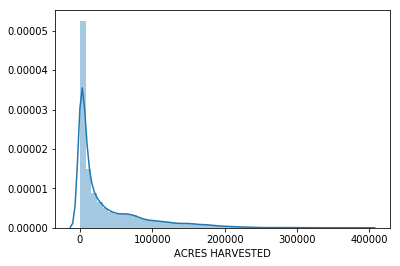

In [93]:
import seaborn as sns
# sns.palplot(sns.color_palette("hls", 8))
corn_plot_df = clean_crop_df.loc[clean_crop_df['CROP']=='CORN']['ACRES HARVESTED']
# clean_crop_df[['ACRES HARVESTED','PRODUCTION','YIELD','PRICE']].hist(figsize=(15,25),layout=(4,1),bins=100, column=clean_crop_df['CROP'])
# , kde=False, rug=True
sns.distplot(corn_plot_df)
plt.show()

In [18]:
# g = sns.FacetGrid(clean_crop_df, col=['ACRES HARVESTED'], hue="CROP", palette="Set1")
# g = (g.map(sns.distplot, "vals", hist=False, rug=True))

****************

## Unemployment Rate
This dataset is from Bureau of Labor Statistics. The downloaded excel workbook consisted of state wise unemployment for every month since Jan 1976 to Nov 2018. The set was split by state with each state in a separate sheet, hence needed to be combined into one large set. And since the crop statistics is on yearly basis, this set needs to be aggregated to yearly numbers.

Once the set is combined and aggregated we write it into another excel file and later manually added as a seperate sheet to rest of the data workbook.

In [95]:
import pandas as pd

Unemployment_xl = os.path.join(fileDir, 'Data\\UnemploymentRate_Raw_ByState_Yearly.xlsx')
xl_sheets = pd.ExcelFile(Unemployment_xl).sheet_names
unemployment_df = pd.DataFrame({})

def read_unemployment_sheet(sheet):
    #Reading one sheet from excel, while only selecting first 5 columns as rest of the columns are empty. 
    df = pd.read_excel(Unemployment_xl, sheet_name=sheet).iloc[:,:5]
    
    #Assigning state name, that's located at 7th row of 2nd column, to seperate column.
    state_name = df.iloc[6,1]
    #print(state_name)
    df['Unnamed: 4']=state_name
    
    #Filtering out all rows above the actual data.
    df = df.iloc[11:,:]
    
    #Renaming columns
    df.columns = ['Year','Period','Month','Unemployment Rate','State']
    
    #Type casting to make sure 'Unemployment Rate' is numeric before taking yearly averages
    df['Unemployment Rate']=pd.to_numeric(df['Unemployment Rate'])
    
    #Takes mean 'Unemployment Rate' across year.
    df['Yearly Unemployment Rate'] = df.groupby('Year')['Unemployment Rate'].transform('mean')
    
    #returns selected columns and dropping duplicates.
    return df[['State','Year','Yearly Unemployment Rate']].drop_duplicates()

for sheet in xl_sheets:
    unemployment_df = unemployment_df.append(read_unemployment_sheet(sheet))
unemployment_df['State']=unemployment_df['State'].str.upper()
unemployment_df['Year']=unemployment_df['Year'].astype('int64')
print(unemployment_df.head())

      State  Year  Yearly Unemployment Rate
11  ALABAMA  1976                  6.766667
23  ALABAMA  1977                  7.316667
35  ALABAMA  1978                  6.316667
47  ALABAMA  1979                  7.175000
59  ALABAMA  1980                  8.883333


In [96]:
writer = pd.ExcelWriter(os.path.join(fileDir, 'Data\\UnemploymentRate_Pivoted_ByState_Yearly.xlsx'))
unemployment_df.to_excel(writer,'US UnemploymentRate', index=False)
writer.save()

Combining Unemployment data with yield.

In [98]:
enriched_df_unemp = pd.merge(filled_df,unemployment_df,how='left')
enriched_df_unemp.head()

,CROP,Year,State,County,ACRES PLANTED,ACRES HARVESTED,PRODUCTION,YIELD,PRICE,Yearly Unemployment Rate
0,BARLEY,1984,ARIZONA,COCHISE,2100.0,2100.0,8467200.0,4032.000000,0.062500,5.175000
1,BARLEY,1985,ARIZONA,COCHISE,900.0,900.0,4200000.0,4666.666667,0.058750,6.333333
2,BARLEY,1986,ARIZONA,COCHISE,500.0,500.0,2016000.0,4032.000000,0.051458,6.925000
3,BARLEY,1987,ARIZONA,COCHISE,500.0,500.0,2304000.0,4608.000000,0.045625,6.450000
4,BARLEY,1989,ARIZONA,COCHISE,500.0,400.0,2116800.0,5292.000000,0.064583,5.358333


### Weather Data

In [99]:
# importing weather data
county_weather_file = os.path.join(fileDir, 'Data\Weather_Historical_US_County_Yearly.xlsx')
county_raw_weather_df = pd.read_excel(county_weather_file)

state_weather_file = os.path.join(fileDir, 'Data\Weather_Historical_US_State_Yearly.xlsx')
state_raw_weather_df = pd.read_excel(state_weather_file)

In [100]:
#Filling nulls in at county level weather columns with state level measurements.
state_weather_df = state_raw_weather_df.copy()
county_weather_df = county_raw_weather_df.copy()


#Having same index makes easy to replace null values from one df to another.
county_weather_df.set_index(['Year','State'],inplace=True)
state_weather_df.set_index(['Year','State'],inplace=True)

county_weather_df = county_weather_df.fillna(state_weather_df).reset_index()
county_weather_df[county_weather_df.isnull().any(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 7 columns):
Year             0 non-null int64
State            0 non-null object
County           0 non-null object
avg_temp         0 non-null float64
max_temp         0 non-null float64
min_temp         0 non-null float64
percipitation    0 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 0.0+ bytes


In [101]:
enriched_df_CST=enriched_df_unemp.copy()

# matching cases to base data
county_weather_df['State'] = county_weather_df['State'].str.upper()
county_weather_df['County'] = county_weather_df['County'].str.upper()

#Cleaning up
# matching county columns on both side
county_weather_df['County_ST']=county_weather_df['County'].str.replace(r'\sPARISH','',regex=True).replace(r'\.','',regex=True).replace(r"\'","",regex=True).replace(r'^SAINT','ST',regex=True).replace(r'\s','',regex=True)
enriched_df_CST['County_ST']=enriched_df_CST['County'].str.replace(r'\sPARISH','',regex=True).replace(r'\.','',regex=True).replace(r"\'","",regex=True).replace(r'^SAINT','ST',regex=True).replace(r'\s','',regex=True)

#merging on matched columns
enriched_df = pd.merge(enriched_df_CST, county_weather_df, how='left', left_on=['Year','State','County_ST'], right_on=['Year','State','County_ST'])

enriched_df = enriched_df.drop(columns=['County_y','County_ST'])
enriched_df.rename(columns={'County_x':'County'},inplace=True)

In [102]:
#dropping rows with no production or acres harvested.
non_null_df = enriched_df[~enriched_df[['ACRES HARVESTED','PRODUCTION']].isnull().any(axis=1)]
non_null_df[['ACRES HARVESTED','PRODUCTION']].isnull().any(axis=1).sum()

0

In [103]:
#Forward fill Barley prices for 2018 from 2017
non_null_df.loc[:,'PRICE']=non_null_df.groupby(['CROP','State','County'])['PRICE'].transform(lambda x: x.fillna('ffill'))
non_null_df['PRICE'].isnull().sum()

0

#### Saving data to file.

In [104]:
corp_writer = pd.ExcelWriter(os.path.join(fileDir, 'Data\Crop_Pivoted.xlsx'))
non_null_df.to_excel(corp_writer,'Crop Data', index=False)
corp_writer.save()